# Problem Set 6: Trees and Forests


## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll at the very least need the train.csv data.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any of the potential predictor variables (i.e., anything except for survival) collinear or highly correlated? 

### Data Dictionary
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

### Notes on data
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# load datasets
train_df = pd.read_csv('titanic_train.csv')
test_df = pd.read_csv('titanic_test.csv')

## combine train and test datasets into one
# titanic_df = pd.concat([train_df, test_df], axis=0, sort=False)

# check first few rows in train dataset
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# # check first few rows in test dataset
# test_df.head()

In [5]:
# variable data types
print(train_df.info())
# print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [6]:
# shape
print(train_df.shape)
# print(test_df.shape)

(891, 12)


In [7]:
# missing values
print("Training data's missing values count and percentage:")
print(pd.concat([train_df.isnull().sum(), (train_df.isnull().sum()*100/891).round(2)], axis=1))

# print("Testing data's missing values count and percentage:")
# print(pd.concat([test_df.isnull().sum(), (test_df.isnull().sum()*100/418).round(2)], axis=1))

Training data's missing values count and percentage:
               0      1
PassengerId    0   0.00
Survived       0   0.00
Pclass         0   0.00
Name           0   0.00
Sex            0   0.00
Age          177  19.87
SibSp          0   0.00
Parch          0   0.00
Ticket         0   0.00
Fare           0   0.00
Cabin        687  77.10
Embarked       2   0.22


### Shape:
Training set has 891 rows and 12 columns.

### Data types:
int64(5): PassengerId, Survived, Pclass, SibSp, Parch

float64(2): Age, Fare

object(5): Name, Sex, Ticket, Cabin, Embarked

### Column names:
Training: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

### Missing values:

Training: Age(177, 19.87%), Cabin(678, 77.10%), Embarked(2，0.22%)

In [8]:
# distribution of each numerical variable
train_df[['Age', 'Fare', "SibSp", "Parch"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000


/Users/qyinhelena/anaconda3/envs/APIs_geospatial/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/qyinhelena/anaconda3/envs/APIs_geospatial/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


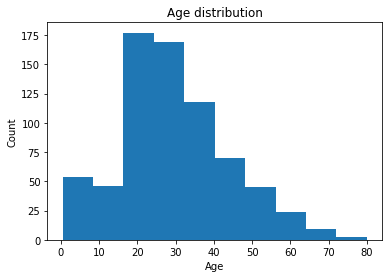

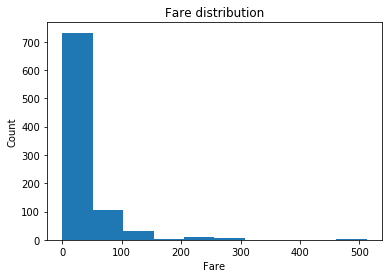

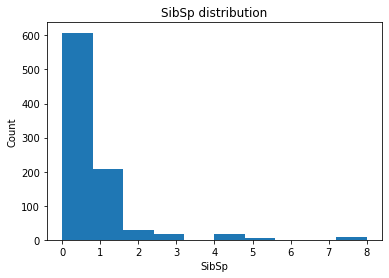

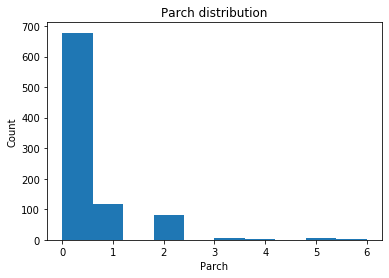

In [9]:
# plot distribution of Numerical Variables (Age, Fare, SibSp, Parch)
def hist_plot(variable):
    plt.hist(train_df[variable])
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title("{} distribution".format(variable))
    plt.show()
# iterate through list of numerical variables
num_var = ['Age', 'Fare', "SibSp", "Parch"]
for var in num_var:
    hist_plot(var)

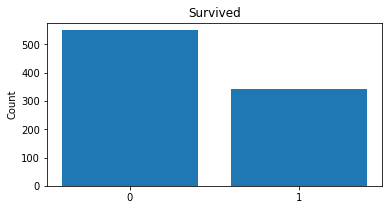

Survived: 
0    549
1    342
Name: Survived, dtype: int64


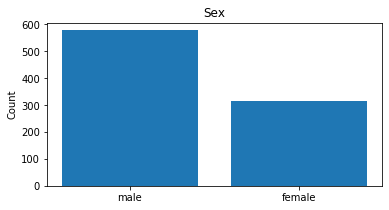

Sex: 
male      577
female    314
Name: Sex, dtype: int64


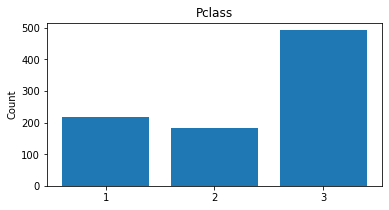

Pclass: 
3    491
1    216
2    184
Name: Pclass, dtype: int64


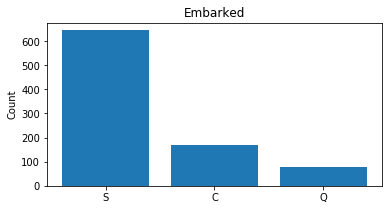

Embarked: 
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [10]:
# value counts of Categorical Variables (Survived, Sex, Embarked, Pclass)
def categ_plot(variable):
    #get feature
    var = train_df[variable]
    #count number of categorical variable (value/sample)
    varValue =var.value_counts()
   
    #visualize 
    plt.figure(figsize = (6,3))
    plt.bar(varValue.index ,varValue)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n{}".format(variable,varValue))

# iterate through list of categorical variables
categ_var = ["Survived","Sex","Pclass","Embarked"]
for var in categ_var:
    categ_plot(var)

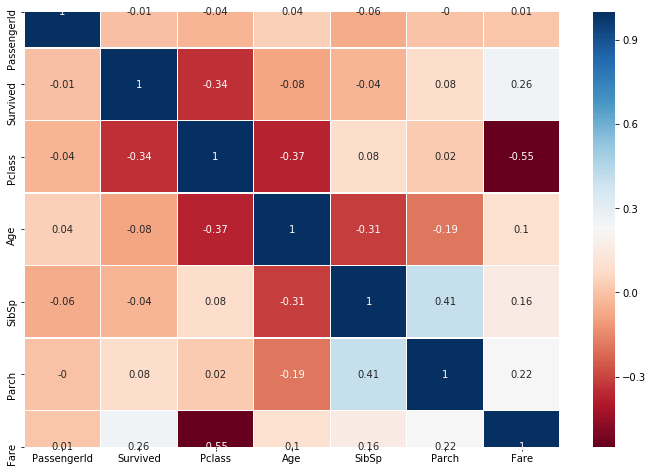

In [11]:
# heatmap to check correlations for each pair of variables
plt.figure(figsize=(12,8))
correlation_matrix = train_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot = True, linewidths= 0.2, cmap="RdBu")
plt.show()

From the heatmap above, positive correlations are found in Pclass and Fare, Pclass and Age, SibSp and Age; negative correlations are found in Parch and Age, Parch and SibSp, Parch and Fare.

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

### Numerical variables
From the heatmap above, we see that fare has positive correlation with survived, meaning people paid for more expensive fare are more likely to survive. Pclass is an ordinal variable, but we find that fare and pclass is negative correlated somehow, and pclass seems to be negative correlated with survived which makes sense. We will look into Pclass in details below.

Parch is slightly positive correlated with survived, meaning the more parents or children in company the more likely to survive.

SibSp is slightly negative correlated with survived, meaning the less siblings and spoudses in company the more likely to survive.

Age is slightly negative correlated with survived, meaning the younger are more likely to survive.

### Categorical variables
#### sex vs survived

In [12]:
pd.crosstab(train_df.Sex,train_df.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


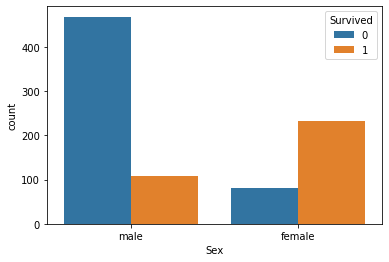

In [13]:
sns.countplot('Sex',hue='Survived',data=train_df)
plt.show()

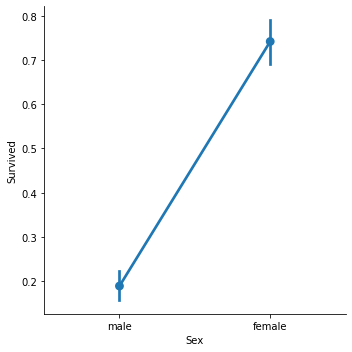

In [14]:
sns.catplot('Sex', 'Survived', data=train_df, kind='point')

#### pclass vs survived

In [15]:
pd.crosstab(train_df.Pclass,train_df.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


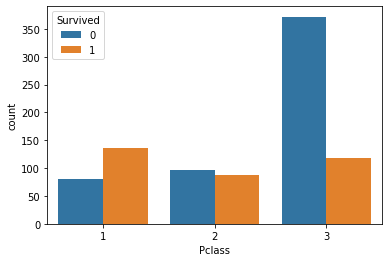

In [16]:
sns.countplot('Pclass',hue='Survived',data=train_df)

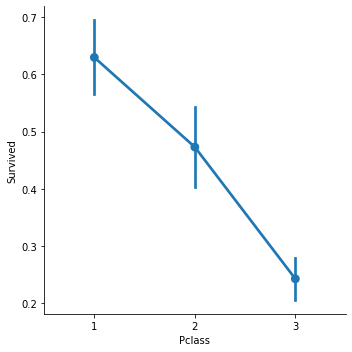

In [17]:
sns.catplot('Pclass', 'Survived', data=train_df, kind='point')

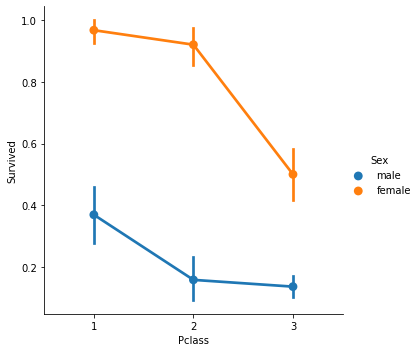

In [18]:
sns.catplot('Pclass', 'Survived', hue='Sex', data=train_df, kind='point')

#### embarked vs survived

In [19]:
pd.crosstab(train_df.Embarked,train_df.Survived,margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


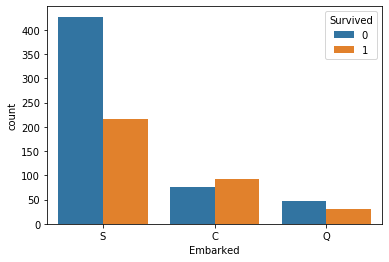

In [20]:
sns.countplot('Embarked', hue= 'Survived',data=train_df)

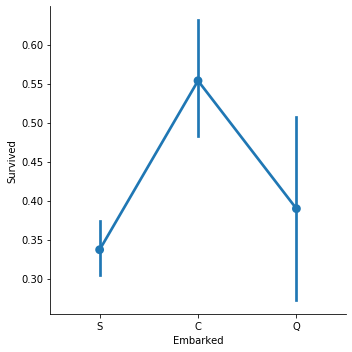

In [21]:
sns.catplot('Embarked', 'Survived', data=train_df, kind='point')

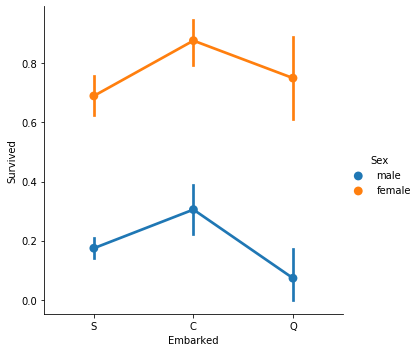

In [22]:
sns.catplot('Embarked', 'Survived', hue='Sex', data=train_df, kind='point')

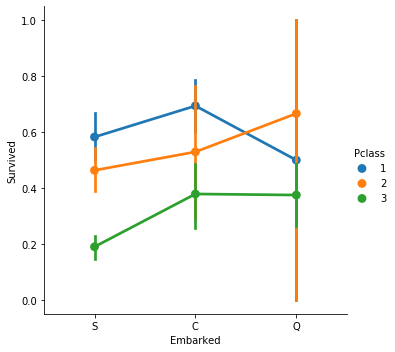

In [23]:
sns.catplot('Embarked', 'Survived', hue='Pclass', data=train_df, kind='point')

Female is more likely to survive than male in general and in segments of Pclass and Embarked. Sex is a very important feature for modeling.

Pclass 1 is more likely to survive than lower classes. This trend hold true for Pclass 1 and 3, but slightly different for Pclass 2. Still, Pclass is an important feature.

Embarking from C port is most likely to survive. However, the ranking of survival for male is C, S, Q and for female is C, Q, S. Overall, Embarked is also important feature.

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation.

For this any the following problems, you should set aside some of your training data as held-out test data, prior to cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels). Finally, select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data -- how does it compare to the cross-validated accuracy?


In [24]:
# Separate features and label
X = train_df.drop(['Survived'], axis=1, inplace=False)
y = train_df['Survived']

# Fill missing Embarked with mode
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

# Split training dataset into 80% training and 20% held-out testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# check shape of train and held-out test
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

(712, 11) (712,) 
 (179, 11) (179,)


In [25]:
# Take features except Name and Cabin
features = ['Pclass', 'Sex', 'Embarked', 'Age', 'SibSp', 'Parch', 'Fare']
entries = X_train[features].to_dict(orient='row')
entries1 = X_test[features].to_dict(orient='row')

# One-hot encoding for Embarked and Sex
# Training set
v = DictVectorizer(sparse=False)
onehot = v.fit(entries)
X1_train = onehot.transform(entries)
y1_train = y_train.values
# Testing set
onehot1 = v.fit(entries1)
X1_test = onehot1.transform(entries1)
y1_test = y_test.values

In [26]:
# Fill missing Age with mean
# Training set
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X1_train)
X1_train = imp_mean.transform(X1_train)
# Testing set
imp_mean1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean1.fit(X1_test)
X1_test = imp_mean1.transform(X1_test)

In [35]:
# Fit data in Decision Tree Classifer, 10-fold cross validation
model1 = DecisionTreeClassifier(criterion='entropy', random_state=0)
cv_scores = cross_val_score(model1, X1_train, y1_train, cv=10)
print(cv_scores)
print('Accuracy for training is', np.mean(cv_scores).round(2))

model1.fit(X1_train, y1_train)
print('Number of leaves: ', model1.get_n_leaves())
print('Number of tree depth', model1.get_depth())

predict_labels = model1.predict(X1_test)
print("Accuracy of testing is {:.2f}".format(sum(predict_labels==y1_test)/len(y1_test)))
print(model1.get_params())

[0.77777778 0.77777778 0.71830986 0.74647887 0.76056338 0.8028169
 0.76056338 0.71830986 0.78873239 0.8028169 ]
Accuracy for training is 0.77
Number of leaves:  160
Number of tree depth 24
Accuracy of testing is 0.78
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}


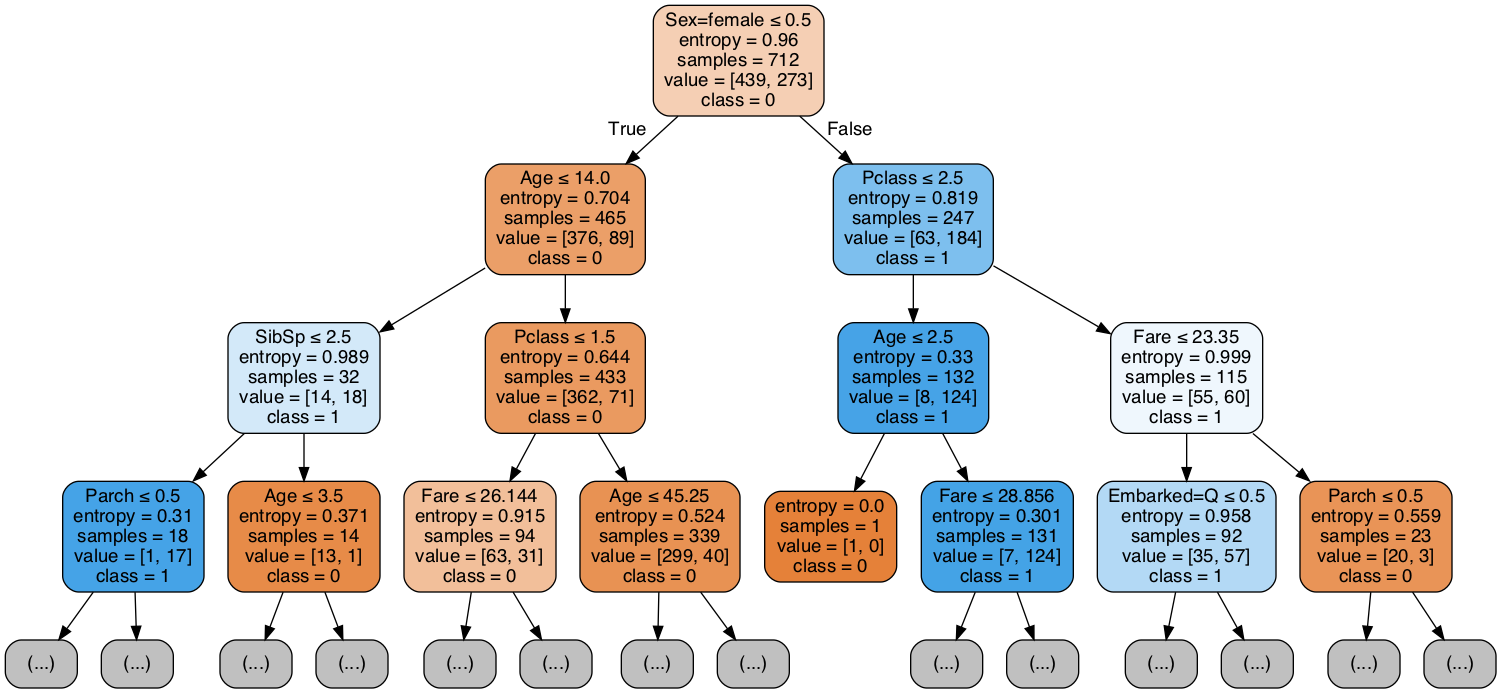

In [36]:
# Plot diagram of decision tree
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(model1, filled = True, max_depth=3,
                           feature_names = v.feature_names_ ,
                           class_names = ['0','1'],
                           rounded = True, special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

The accuracy is 78%, slightly better than the cross-validated accuracy.

### 2.2 Features

Use all of the data (minus the held-out data) to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

In [41]:
model2 = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
model2.fit(X1_train, y1_train)
print('Feature names:\n', v.feature_names_)
print('Feature importance:\n', model2.feature_importances_)
print('Feature params:\n', model2.get_params())
print('Accuracy of training:\n', model2.score(X1_train, y1_train).round(2))
print('Accuracy of testing:\n', model2.score(X1_test, y1_test).round(2))

Feature names:
 ['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch', 'Pclass', 'Sex=female', 'Sex=male', 'SibSp']
Feature importance:
 [0.09118709 0.         0.0161937  0.         0.07705225 0.0228676
 0.20059348 0.52141873 0.         0.07068715]
Feature params:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}
Accuracy of training:
 0.84
Accuracy of testing:
 0.82


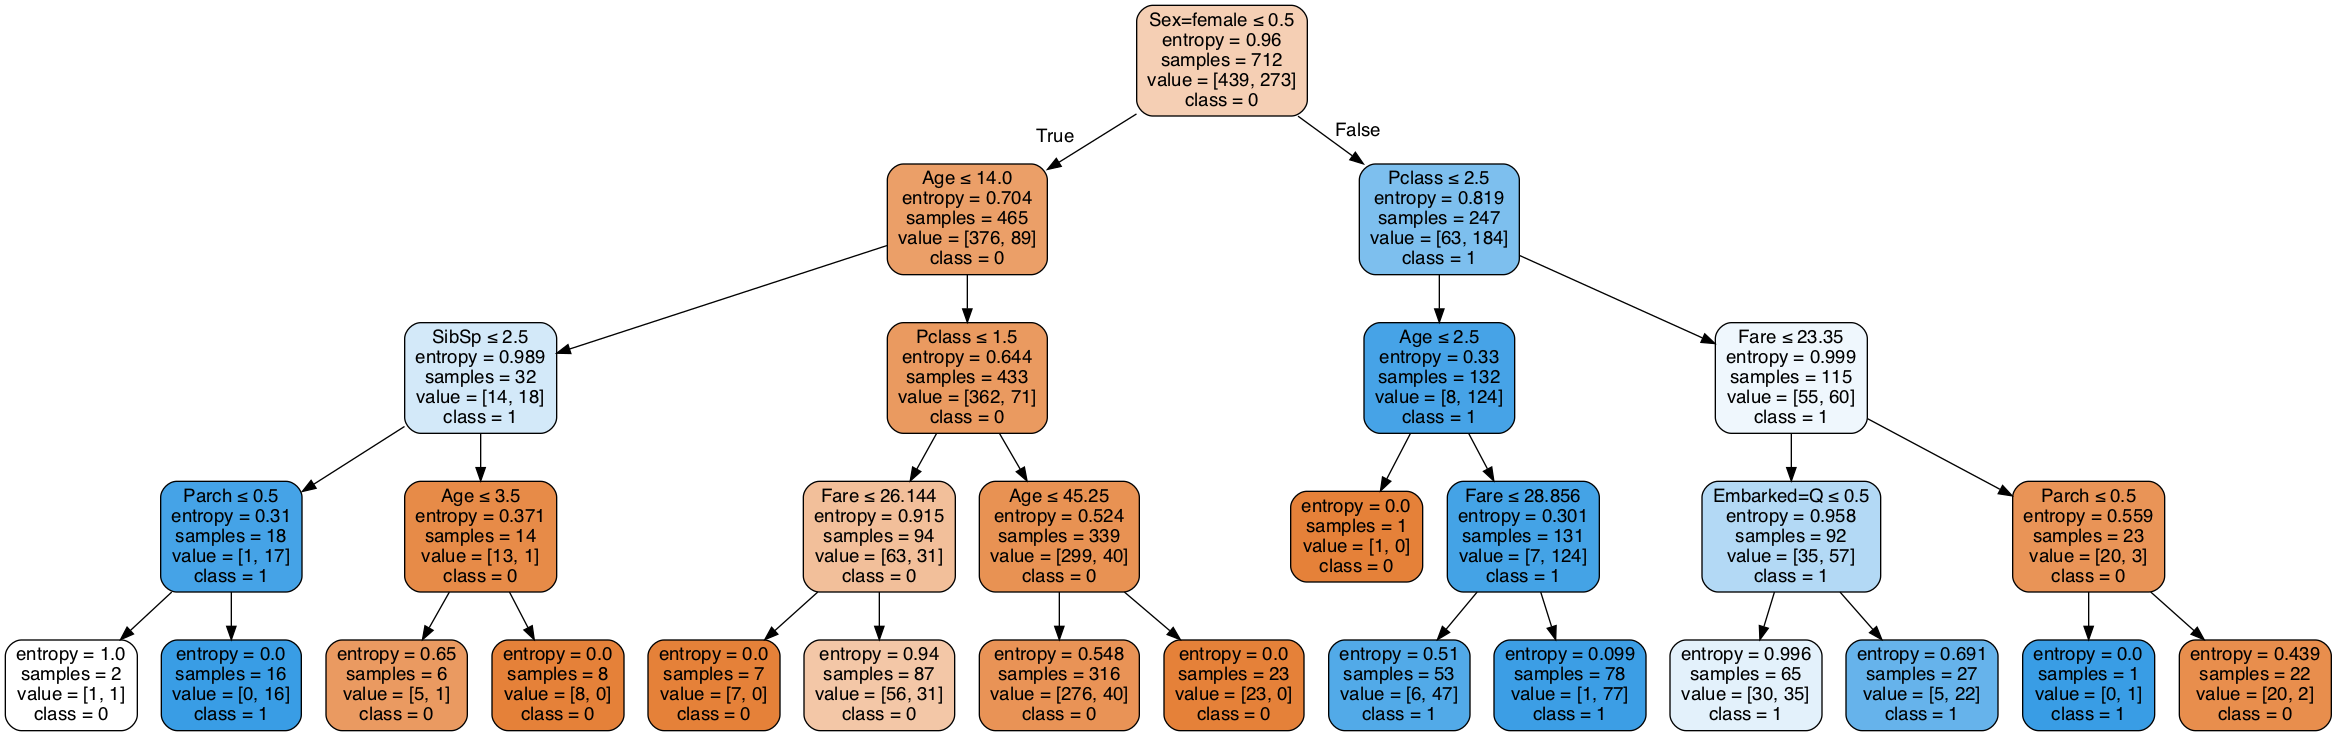

In [44]:
# plot diagram of decision tree
dot_data2 = export_graphviz(model2, filled = True,
                           feature_names = v.feature_names_ ,
                           class_names = ['0','1'],
                           rounded = True, special_characters = True)
graph2 = pydotplus.graph_from_dot_data(dot_data2)

Image(graph2.create_png())

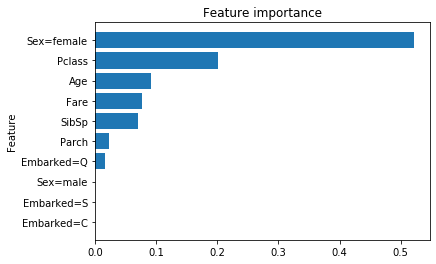

In [43]:
# Plot feature importances
features_plot = v.feature_names_
importances = model2.feature_importances_
idx = np.argsort(importances) # sort ascendingly, mark index
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features_plot[i] for i in idx])
plt.ylabel("Feature")
plt.show()

Some features such as Sex-male, Embarked-S, Embarked-C have 0 feature importance over all nodes. Among all, Sex-female, Pclass, Age, Fare, SibSp are important features when we set max depth at 4.

### 2.3 Tree Tuning
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy. Do not use your held-out test data.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

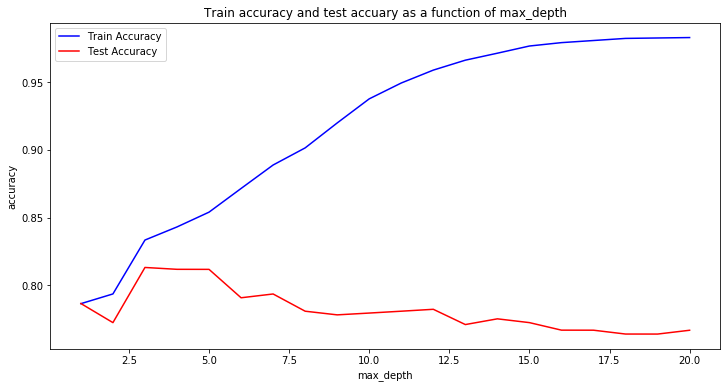

In [54]:
# Tune max_depth in range of 1 to 20
depth_metrics = list(range(1, 21))

train_scores, test_scores = [], []
for depth in depth_metrics:
    model3 = DecisionTreeClassifier(random_state=0, max_depth=depth)
    cv_scores = cross_validate(model3, X1_train, y1_train, cv=10, return_train_score=True)
    train_scores.append(np.mean(cv_scores['train_score']))
    test_scores.append(np.mean(cv_scores['test_score']))

# Plot train and test accuracies as a function of max_depth 
plt.figure(figsize=(12,6))
plt.plot(depth_metrics, train_scores, label='Train Accuracy', c='b')
plt.plot(depth_metrics, test_scores, label='Test Accuracy', c='r')
plt.legend(loc='upper left')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Train accuracy and test accuary as a function of max_depth')
plt.show()

In [71]:
# Tune both max_depth and min_samples_leaf
minleaf_metrics = list(range(1, 21))

accuracy_scores = []
depth_minleaf = []
for depth in depth_metrics:
    for minleaf in minleaf_metrics:
        model4 = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=minleaf)
        accuracy_score = cross_validate(model4, X1_train, y1_train, cv=10)
        accuracy_scores.append(np.mean(accuracy_score['test_score']))
        depth_minleaf.append([depth, minleaf])

In [72]:
# Print the max accuracy score
print('Index of the max accuracy score:', np.asarray(accuracy_scores).argmax())
print('Max accuracy score: ', max(accuracy_scores).round(2))

Index of the max accuracy score: 125
Max accuracy score:  0.82


In [74]:
# Print the combinatoin of max_depth and min_sampels_leaf to achieve max accuracy score
print('Max_depth and Min_samples_leaf are:', depth_minleaf[125])

Max_depth and Min_samples_leaf are: [7, 6]


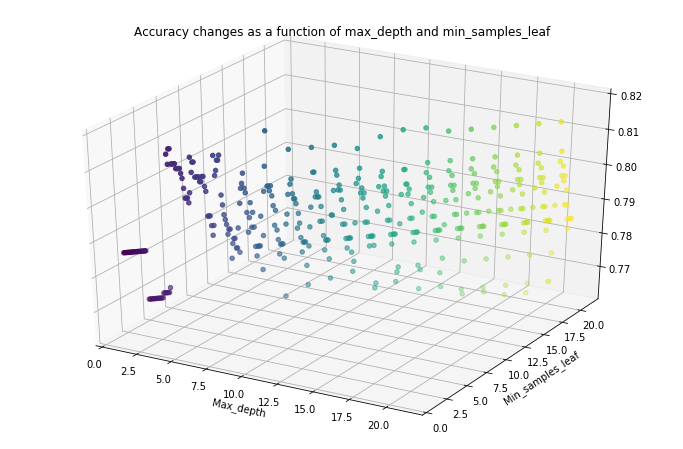

In [100]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xs=np.linspace(1,21,len(accuracy_scores)),
              ys=np.linspace(1,21,len(accuracy_scores)),
              zs=accuracy_scores, c=range(0,len(accuracy_scores)))
plt.xlabel('Max_depth')
plt.ylabel('Min_samples_leaf')
plt.title('Accuracy changes as a function of max_depth and min_samples_leaf')
plt.show()

When max_depth is 7 and min_samples_leaf is 6, the model achieves max accuracy score = 0.82

### 2.4 Support Vector Machines, for comparison

Now use an [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to predict survival, using  the default value for the constant penalization (C=1).  Report your accuracy on the test and train sets. 

Use cross-validation to determine a possibly better choice for C. Note that regularization is inversely proportional to the value of C in sklearn, i.e. the higher value you choose for C the less you regularize. 
    
    
* How does the test performance with SVM for your best choice of C compare to the decision tree performance?


In [96]:
from sklearn.svm import SVC

model5 = SVC(C=1) # constant penalization C=1
model5.fit(X1_train, y1_train)
svm_pred = model5.predict(X1_test)
print("Accuracy of SVM on testing is {}".format((sum(svm_pred==y1_test)/len(y1_test)).round(2)))
svm_train = model5.predict(X1_train)
print("Accuracy of SVM on training is {}".format((sum(svm_train==y1_train)/len(y1_train)).round(2)))

Accuracy of SVM on testing is 0.72
Accuracy of SVM on training is 0.67


In [107]:
# Cross validate to tune C
c_metrics = list(range(1,31))

cv_svm_scores = []
for c in c_metrics:
    model6 = SVC(C=c)
    model6.fit(X1_train, y1_train)
    cv_svm_score = cross_validate(model6, X1_train, y1_train, cv=10)
    cv_svm_scores.append(np.mean(cv_svm_score['test_score']))

print('Index of the max accuracy score:', np.asarray(cv_svm_scores).argmax())
print('Max accuracy score: ', max(cv_svm_scores).round(2))

Index of the max accuracy score: 29
Max accuracy score:  0.79


In [109]:
# Use C=29 to run SVM model
model7 = SVC(C=29)
model7.fit(X1_train, y1_train)
print('Accuracy of SVM on training:', model7.score(X1_train, y1_train).round(2))
print('Accuracy of SVM on testing:', model7.score(X1_test, y1_test).round(2))

Accuracy of SVM on training: 0.8
Accuracy of SVM on testing: 0.78


The best C of 29 on SVM gets 0.78 accuracy. The decision tree model on max_depth of 7 and min_samples_leaf of 6 gets 0.82 accuracy. The decision tree wins.

### 2.5 Missing Data
Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Do any of your features have missing data? If so, which ones? What percent of observations have missing data?
* What happens to observations with missing data when you run the decision tree and SVM models above?
* Use one of the methods we discussed in class to impute missing values
* Rerun your decision tree and SVM on the new dataset with imputed missing values. What do you notice?

In [115]:
# No missing values in the datasets
print(np.isnan(X1_train).sum())
print(np.isnan(X1_test).sum())

0
0


In 2.1, I have imputed the missing values in age with mean, and in embarked with mode.
As stated in 1.1, Training set has number of missing values and percentages as the following.

Age(177, 19.87%), Cabin(678, 77.10%), Embarked(2，0.22%)

I imagine if drop all missing values, we will have lower accuracy rates than imputed missing values. The more data the better for traininig models in general. Given the percentages of missing value in the dataset is quite big, we should not simply drop missing values.

## Part 3: Forests

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters. 
* What hyperparameters did you select with cross-validation?
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and SVM?
* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

In [119]:
from sklearn.ensemble import RandomForestClassifier

model8 = RandomForestClassifier(random_state=0)
model8.fit(X1_train, y1_train)
predict_rf = model8.predict(X1_test)
print("Accuracy of random forest is {}".format((sum(predict_rf==y1_test)/len(y1_test)).round(2)))

Accuracy of random forest is 0.85


In [214]:
# Tune parameters with GridSearchCV
parameters_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': list(range(1,11)), 
              'max_features': list(range(1,11))}
model9 = RandomForestClassifier(random_state=0)
cr_val = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(model9, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X1_train, y1_train)

print('Best score: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.839
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 4}


In [220]:
model9_best = grid_search.best_estimator_
print('Best random forest model accuracy score: ', model9_best.score(X1_test, y1_test).round(3))

Best random forest model accuracy score:  0.838


In [213]:
cv_scores_rf = cross_validate(model9_best, X1_train, y1_train, cv=10,return_train_score=True)
train_score_rf = np.mean(cv_scores_rf['train_score'])
test_score_rf = np.mean(cv_scores_rf['test_score'])
print('Best random forest model on training scores: ',train_score_rf.round(2))
print('Best random forest model on testing scores: ',test_score_rf.round(3))

Best random forest model on training scores:  0.87
Best random forest model on testing scores:  0.839


The cross validation of random forest model selects 3 hyperparameters: criterion, max_depth, and max_features.

Cross-validated performance gets accuracy of 0.839 and top peforming model on test set has accuracy of 0.839. They are the same.

The best C of 29 on SVM gets 0.78 accuracy. The decision tree model on max_depth of 7 and min_samples_leaf of 6 gets 0.82 accuracy. The best random forest with max_depth of 6 and max_features of 4 gets 0.84 accuracy. Random forest wins.

In [197]:
# Tune n_estimator (number of trees in random forest) in range 1 to 20
scores_rf = []
for n in range(1,21):
    model10 = RandomForestClassifier(n_estimators=n,random_state=0,criterion='entropy',max_depth= 6,max_features=8)
    score_rf = cross_validate(model10, X1_train, y1_train, cv=10)
    scores_rf.append(score_rf['test_score'])

scores_rf = np.array(scores_rf)

In [ ]:
tree_nums = np.multiply(np.arange(1,21).reshape(-1,1), np.ones(10,dtype=int))

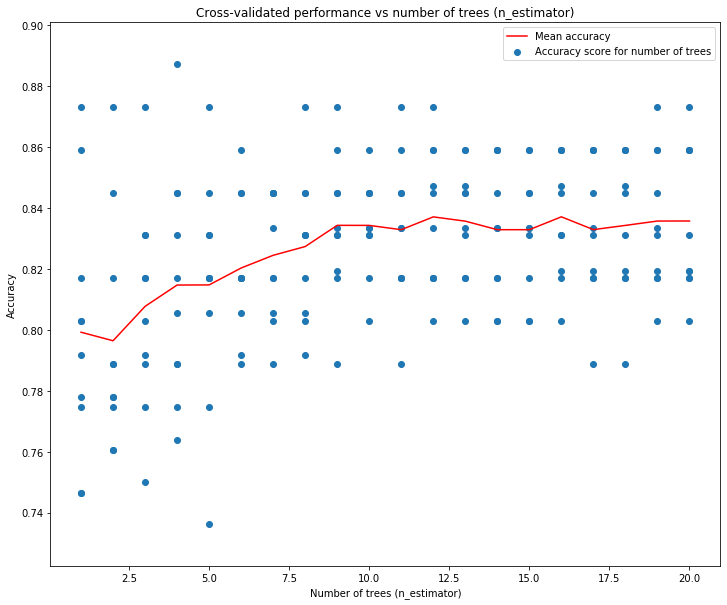

In [205]:
# Plot cross-validated performance vs number of trees (n_estimator)
plt.figure(figsize=(12,10))
plt.scatter(x=tree_nums, y=scores_rf, label='Accuracy score for number of trees')
plt.plot(np.arange(1,21), scores_rf.mean(axis=1), c='r', label='Mean accuracy')
plt.xlabel('Number of trees (n_estimator)')
plt.ylabel('Accuracy')
plt.title('Cross-validated performance vs number of trees (n_estimator)')
plt.legend(loc='upper right')
plt.show()

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters. 
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [206]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {'loss':['deviance', 'exponential'],
                 'learning_rate':np.arange(0.01,0.2,0.01)}
              
model11 = GradientBoostingClassifier(random_state=0)
cr_val = StratifiedKFold(n_splits=10)
grid_search_gb = GridSearchCV(model11, param_grid=param_grid_gb, cv=cr_val)
grid_search_gb.fit(X1_train, y1_train)
model11_best = grid_search_gb.best_estimator_

In [222]:
print('Best score on training set: {}'.format((grid_search_gb.best_score_).round(3)))
print('Best parameters: {}'.format(grid_search_gb.best_params_))

Best score on training set: 0.833
Best parameters: {'learning_rate': 0.17, 'loss': 'deviance'}


In [212]:
print("Best gradient boosting model on testing scores: ", model11_best.score(X1_test, y1_test).round(3))

Best gradient boosting model on testing scores:  0.844


The best gradient boosting model scores 0.844 which is slightly better than the best random forest model scoring 0.839.

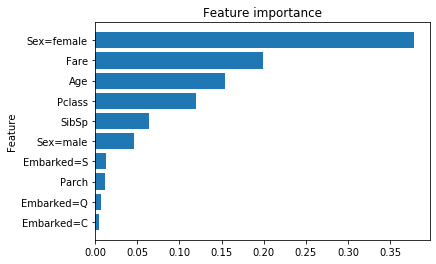

In [218]:
# Plot feature importances
features_plot = v.feature_names_
importances = model11_best.feature_importances_
idx = np.argsort(importances) # sort ascendingly, mark index
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features_plot[i] for i in idx])
plt.ylabel("Feature")
plt.show()

### 3.3 Feature Engineering
Revisit the features in your dataset.
* Are each of the features being appropriately included in the analysis? 
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Create a final table that summarizes the performance of your models as follows:

| Model | Cross-validated Performance   | Test Performance | 
|------|------|------|
|   Decision Tree        |  |  |
|   Decision Tree (with imputed missing values and new features)        |  |  |
|   SVM  |  |  |
|   SVM (with imputed missing values and new features)        |  |  |
|   Random Forest        |  |  |
|   Random Forest (with imputed missing values and new features)        |  |  |
|   Gradient Boosting    |  |  | 
|   Gradient Boosting (with imputed missing values and new features)        |  |   x |


In [223]:
d = {'Model': ['Decision Tree','Decision Tree (with imputed missing values and new features)',
                 'SVM','SVM (with imputed missing values and new features)',
                 'Random Forest','Random Forest (with imputed missing values and new features',
                 'Gradient Boosting','Gradient Boosting (with imputed missing values and new features)'],

    'Cross-validated Performance':['0.77','0.84','0.72','0.79','0.838','0.838','0.833','0.833'],

    'Test Performance':['0.82','0.82','0.78','0.78','0.839','0.839','0.844','0.844']}

Feature_eng_df = pd.DataFrame(d)
Feature_eng_df

,Model,Cross-validated Performance,Test Performance
0,Decision Tree,0.77,0.82
1,Decision Tree (with imputed missing values and...,0.84,0.82
2,SVM,0.72,0.78
3,SVM (with imputed missing values and new featu...,0.79,0.78
4,Random Forest,0.838,0.839
5,Random Forest (with imputed missing values and...,0.838,0.839
6,Gradient Boosting,0.833,0.844
7,Gradient Boosting (with imputed missing values...,0.833,0.844


It would be great to use Name to identify text such as Mr. Miss. Mrs. so that when imputing missing values for Age, we can possibly use the mean from that age and sex combination group and get better performance in the end. However, I don't have time to finish this part. 

## Part 4 (extra credit): Neural Networks

###  Let's get familiar with neural networks!
Now, try to predict survival on the Titanic using feed forward neural networks. This will likely be easiest with [TensorFlow](https://www.tensorflow.org/), as highlighted in the lab section.

For this problem, you are responsible for choosing the number of layers, their corresponding size, the activation functions, and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish. Your goal is to tune those parameters so that your test accuracy is higher than 83%. Make sure you process your data appropriately before training your networks.

* Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

* It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates and batch sizes to get a feeling of how they affect neural network training. No need to report anything here. 


In [ ]:
# Enter your code here
import tensorflow as tf